In [233]:
# Cell 1
import pandas as pd
import numpy as np
import nltk
import pickle
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
import tensorflow as tf

In [234]:
# Cell 2
# Load your Excel files for validation
validation_file_path = '/Users/PremGanesh/Developer/AI/CyVidia/Input_Data/validation_rbi.xlsx'
validation_df = pd.read_excel(validation_file_path)
output_file_path = '/Users/PremGanesh/Developer/AI/CyVidia/Output_Data/TV9_validation_jll_2.xlsx'
# Model Name
model_name = 'trained_model_rbi_jll_nist_scf'
# Define column names
req_no_col = 'ReqNo'
req_area_col = 'Requirement Area'
req_area_nist_col = 'Requirement Area (NIST)'
req_bucket_nist_col = 'Requirement Bucket(NIST)'
predicted_area_col = 'Predicted_Area'
suggested_area_col ='Suggested_Area'
predicted_bucket_col = 'Predicted_Bucket'
key_words_col = 'Key Words'
type_col = 'Type'
source_type_col = 'Source Type'
source_col = 'Source'
source_detail_col = 'Source Detail'
source_req_id_col = 'Source Requirement ID#'

In [235]:
# Cell 3
# Load the saved tokenizer using pickle
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [236]:
# Cell 4
# Load the encoders from the training process
with open('area_encoder.pickle', 'rb') as handle:
    area_encoder = pickle.load(handle)
with open('bucket_encoder.pickle', 'rb') as handle:
    bucket_encoder = pickle.load(handle)

In [237]:
# Cell 5
# Define a function for text cleaning
def clean_text(text):
    if isinstance(text, float) and np.isnan(text):
        return ""
    words = word_tokenize(text)
    words = [word.lower() for word in words if word.isalnum()]
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    clean_text = ' '.join(words)
    return clean_text

In [238]:
# Cell 6
# Apply text cleaning to 'Requirement Description' column for validation data
validation_df['Cleaned_Description'] = validation_df['Requirement Description'].apply(clean_text)

In [239]:
# Cell 7
# Tokenize and pad sequences for validation data
max_words = 1000
X_val = tokenizer.texts_to_sequences(validation_df['Cleaned_Description'])
X_val = pad_sequences(X_val, maxlen=100)

In [240]:
# Cell 8
# Load the saved model
loaded_model = load_model(model_name)

In [241]:
# Cell 9
# Predict on validation data using the loaded model
y_pred = loaded_model.predict(X_val)

5/5 [==============================] - 3s 145ms/step


In [242]:
# Cell 10
# Get prediction scores for 'Area' and 'Bucket'
prediction_scores_area = np.max(y_pred[0], axis=1)
prediction_scores_bucket = np.max(y_pred[1], axis=1)

In [243]:
# Cell 11
# Add the prediction scores to the validation DataFrame
validation_df['Prediction_Score_Area'] = prediction_scores_area
validation_df['Prediction_Score_Bucket'] = prediction_scores_bucket

In [244]:
# Cell 12
# Define a labeling threshold (e.g., 0.85)
labeling_threshold = 0.85

In [245]:
# Cell 13
# Initialize lists to store predicted labels and suggested labels
predicted_labels_area = []
suggested_labels_area = []
predicted_labels_bucket = []
suggested_labels_bucket = []

In [246]:
# Cell 14
# Iterate through predictions and apply labeling/suggestion logic
for pred_area, score_area, pred_bucket, score_bucket in zip(
    np.argmax(y_pred[0], axis=1),
    prediction_scores_area,
    np.argmax(y_pred[1], axis=1),
    prediction_scores_bucket
):
    if score_area >= labeling_threshold:
        predicted_labels_area.append(area_encoder.inverse_transform([pred_area])[0])
        suggested_labels_area.append('')
    else:
        predicted_labels_area.append('Other')
        suggested_labels_area.append(area_encoder.inverse_transform([pred_area])[0])

    if score_bucket >= labeling_threshold:
        predicted_labels_bucket.append(bucket_encoder.inverse_transform([pred_bucket])[0])
        suggested_labels_bucket.append('')
    else:
        predicted_labels_bucket.append('Other')
        suggested_labels_bucket.append(bucket_encoder.inverse_transform([pred_bucket])[0])

In [247]:
# Cell 15
# Add the predicted labels and suggested labels to the validation DataFrame
validation_df[predicted_area_col] = predicted_labels_area
validation_df[suggested_area_col] = suggested_labels_area
validation_df[predicted_bucket_col] = predicted_labels_bucket
validation_df['Suggested_Bucket'] = suggested_labels_bucket

In [248]:
# Cell 16
# Save the validation results DataFrame to an Excel file
validation_results_file_path = output_file_path
validation_df.to_excel(validation_results_file_path, index=False)
print("Validation results with predicted/suggested labels and scores saved to", validation_results_file_path)

Validation results with predicted/suggested labels and scores saved to /Users/PremGanesh/Developer/AI/CyVidia/Output_Data/TV9_validation_jll_2.xlsx


In [249]:
# Read the Excel file
df = pd.read_excel(output_file_path)


In [250]:
# Convert the predicted_area into lower case
df[req_area_nist_col] = df[req_area_nist_col].str.lower()
df[req_bucket_nist_col] = df[req_bucket_nist_col].str.lower()

In [251]:
def calculate_validation(row):
    area_validation = ""
    bucket_validation = ""

    if not pd.isna(row[req_area_nist_col]) and not pd.isna(row[predicted_area_col]):
        if row[req_area_nist_col] == row[predicted_area_col]:
            area_validation = 'Correct'
        elif row[predicted_area_col] == 'Other' and not pd.isna(row[suggested_area_col]) and row[suggested_area_col] == row[req_area_nist_col]:
            area_validation = 'Correct'
        else:
            area_validation = 'Incorrect'
    else:
        area_validation = 'Empty'

    if not pd.isna(row[req_bucket_nist_col]) and not pd.isna(row[predicted_bucket_col]):
        if row[req_bucket_nist_col] == row[predicted_bucket_col]:
            bucket_validation = 'Correct'
        elif row[predicted_bucket_col] == 'Other' and not pd.isna(row['Suggested_Bucket']) and row['Suggested_Bucket'] == row['Requirement Bucket(NIST)']:
            bucket_validation = 'Correct'
        else:
            bucket_validation = 'Incorrect'
    else:
        bucket_validation = 'Empty'

    return area_validation, bucket_validation

In [252]:
# Apply the function to create new columns
df['Area Validation'], df['Bucket Validation'] = zip(*df.apply(calculate_validation, axis=1))
# add the validation area and bucket to the excel file and save it to the output    
df.to_excel(output_file_path, index=False)

In [253]:
# Calculate counts for 'Area Validation' and 'Bucket Validation'
area_validation_counts = df['Area Validation'].value_counts()
bucket_validation_counts = df['Bucket Validation'].value_counts()

In [254]:
# Calculate percentages for 'Area Validation Accuracy' and 'Bucket Validation Accuracy'
area_validation_accuracy = (area_validation_counts.get('Correct', 0) / (area_validation_counts.sum())) * 100
bucket_validation_accuracy = (bucket_validation_counts.get('Correct', 0) / (bucket_validation_counts.sum())) * 100

In [255]:
# Create a dictionary with the counts and percentages
validation_summary = {
    'Total Count': len(df),
    'Area Validation Correct Count': area_validation_counts.get('Correct', 0),
    'Area Validation Incorrect Count': area_validation_counts.get('Incorrect', 0),
    'Area Validation Empty Count': area_validation_counts.get('Empty', 0),
    'Bucket Validation Correct Count': bucket_validation_counts.get('Correct', 0),
    'Bucket Validation Incorrect Count': bucket_validation_counts.get('Incorrect', 0),
    'Bucket Validation Empty Count': bucket_validation_counts.get('Empty', 0),
    'Area Validation Accuracy': area_validation_accuracy,
    'Bucket Validation Accuracy': bucket_validation_accuracy
}

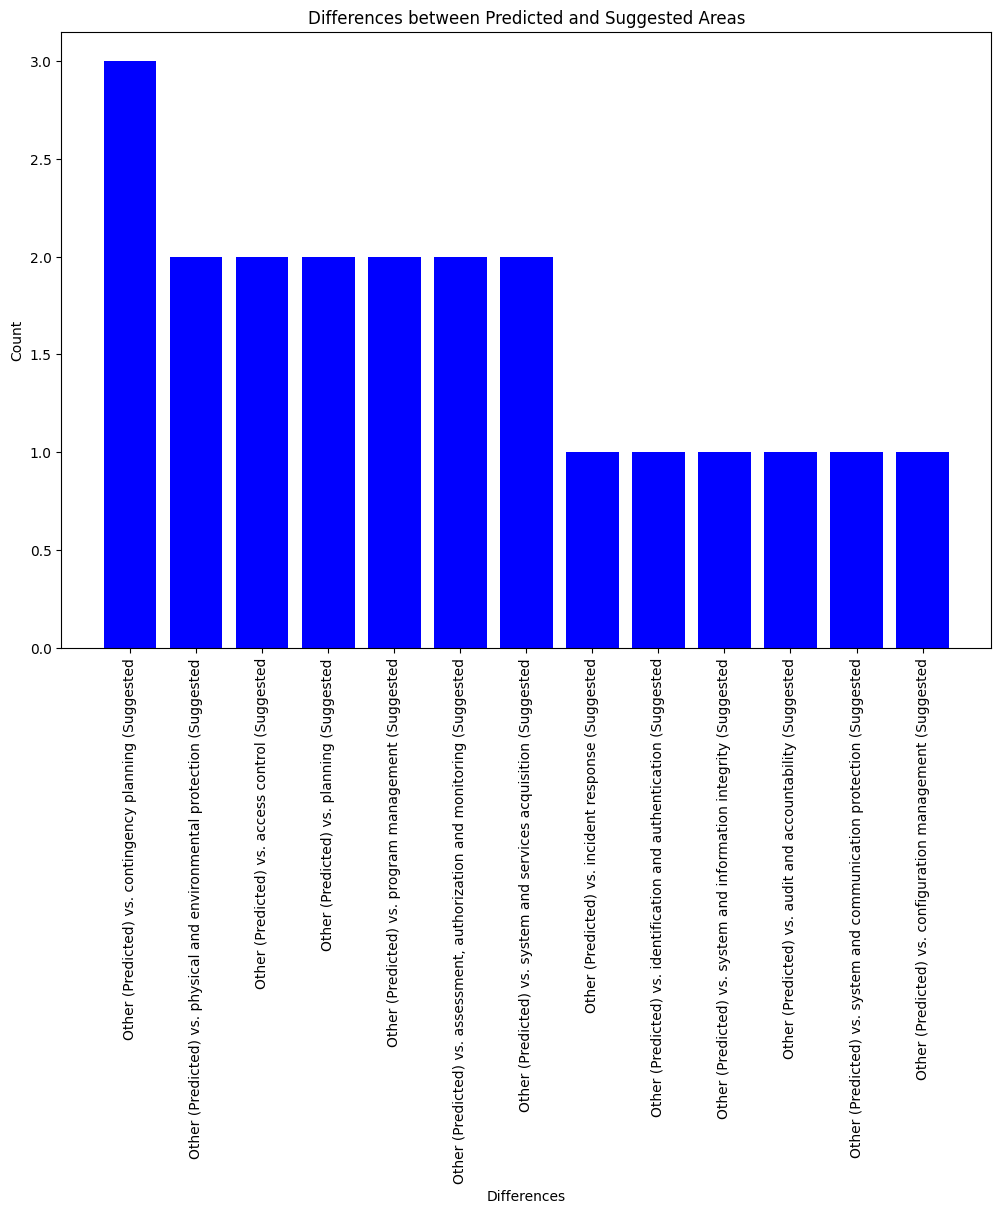

In [256]:
import matplotlib.pyplot as plt
# Plot the differences between Predicted and Suggested Areas
differently_mapped = df[df['Area Validation'] == 'Incorrect'][[predicted_area_col, suggested_area_col]]
differently_mapped['Area Difference'] = differently_mapped[predicted_area_col] + " (Predicted) vs. " + differently_mapped[suggested_area_col] + " (Suggested"
difference_counts = differently_mapped['Area Difference'].value_counts()

plt.figure(figsize=(12, 8))

plt.bar(difference_counts.index, difference_counts, color='blue')

plt.title('Differences between Predicted and Suggested Areas')
plt.xlabel('Differences')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

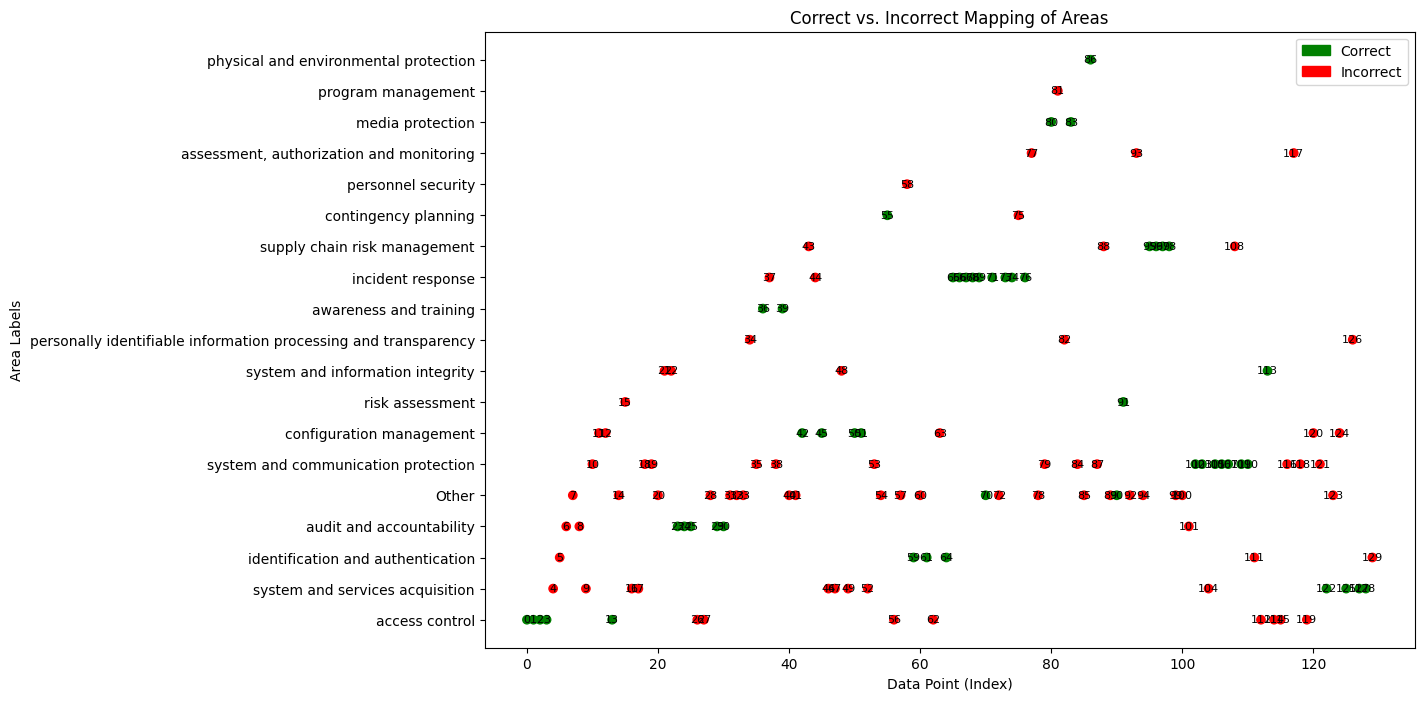

In [257]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Create a DataFrame to store the correctness and colors
correctness_colors = pd.DataFrame({
    'Correctness': df['Area Validation'],
    'Color': df['Area Validation'].apply(lambda x: 'green' if x == 'Correct' else 'red')
})

# Scatter plot to visualize correctness
plt.figure(figsize=(12, 8))

# Scatter the data points
scatter = plt.scatter(df.index, df[predicted_area_col], c=correctness_colors['Color'], marker='o')

plt.title('Correct vs. Incorrect Mapping of Areas')
plt.xlabel('Data Point (Index)')
plt.ylabel('Area Labels')

# Add labels to the data points
for i, label in enumerate(df.index):
    plt.annotate(label, (label, df[predicted_area_col][i]), fontsize=8, ha='center', va='center', color='black')

# Create a legend
correct_patch = mpatches.Patch(color='green', label='Correct')
incorrect_patch = mpatches.Patch(color='red', label='Incorrect')
plt.legend(handles=[correct_patch, incorrect_patch])
plt.show()

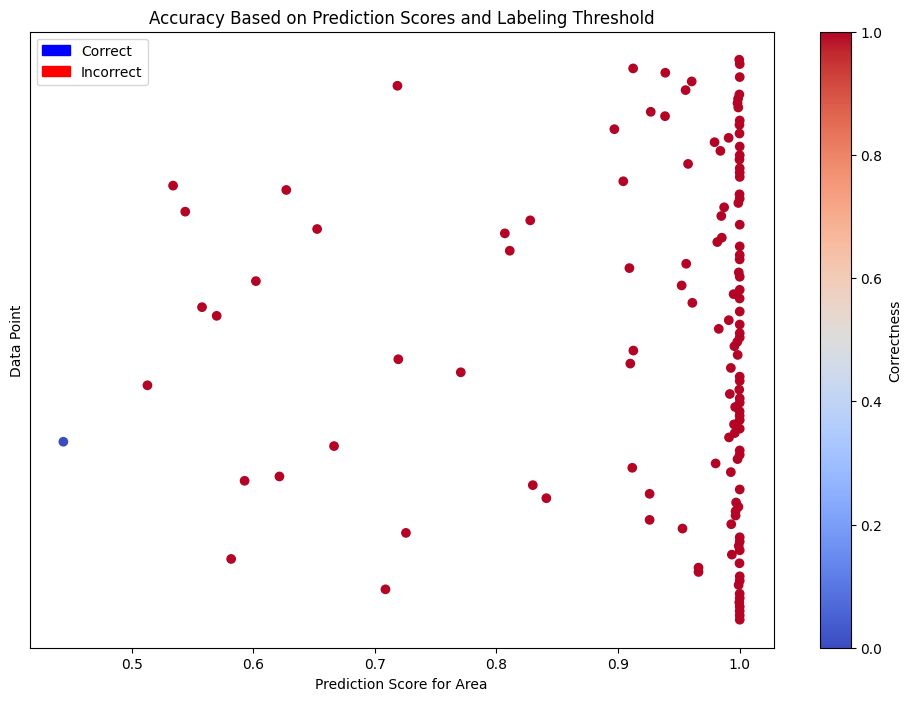

In [258]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Define the labeling threshold
labeling_threshold = 0.5  # Adjust this threshold as needed

# Determine correctness based on prediction scores and labeling threshold
correctness = (df['Prediction_Score_Area'] >= labeling_threshold)

# Scatter plot to visualize correctness based on threshold
plt.figure(figsize=(12, 8))

# Scatter the data points
plt.scatter(df['Prediction_Score_Area'], df.index, c=correctness, cmap='coolwarm', marker='o')

plt.title('Accuracy Based on Prediction Scores and Labeling Threshold')
plt.xlabel('Prediction Score for Area')
plt.ylabel('Data Point')
plt.yticks([])

# Create a colorbar for the scatter plot
cbar = plt.colorbar()
cbar.set_label('Correctness')

# Add a legend
correct_patch = mpatches.Patch(color='blue', label='Correct')
incorrect_patch = mpatches.Patch(color='red', label='Incorrect')
plt.legend(handles=[correct_patch, incorrect_patch])
plt.show()

In [259]:
# Convert the dictionary to a DataFrame and transpose it
summary_df = pd.DataFrame(validation_summary, index=[0]).T

In [260]:
# Rename the column
summary_df = summary_df.rename(columns={0: 'Count'})
# Save the validation summary to an Excel file
validation_summary_file_path = output_file_path+'_summary.xlsx'
summary_df.to_excel(validation_summary_file_path)
print("Validation summary saved to", validation_summary_file_path)
print('output validation file path ' ,output_file_path)

Validation summary saved to /Users/PremGanesh/Developer/AI/CyVidia/Output_Data/TV9_validation_jll_2.xlsx_summary.xlsx
output validation file path  /Users/PremGanesh/Developer/AI/CyVidia/Output_Data/TV9_validation_jll_2.xlsx
